# Artist Recommendation

Authors:
Michel Haddad, Rima Al-Ghossein

Scraping code and dataset : https://github.com/michelhaddad/graph-mining-final-project

Spotify users create playlists and we would love to help them add more songs to them. Therefore, we decided to predict the artists whose songs the user would enjoy adding to a playlist.

To achieve our goal, we decided to apply many strategies by leveraging a graph of relationships between artists and compare them with strategies we could apply manually to assess their performance. We collected the artists that are in 8 playlists and will be scoring the strategies based on their average performance on these playlists.

## Performance Measure Metric
Given a strategy's predictions, we're measuring the performance by the ratio of artists predicted that are in the playlist over the total number of artists predicted by the strategy.

### Brief Overview Of The Graph

We've built a directed graph, whereby an edge exists between some artist A and some other artist B only if B belongs to A's related artists. The related artists are fetched using spotify's Public API. We provided an image for clarity.

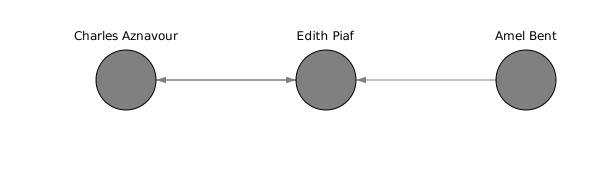

In [ ]:
adjacency = csr_matrix(np.array([[0, 1, 0], [1, 0, 0], [0, 1, 0]]))
position = np.array([[0, 10], [100, 10], [200, 10]])
names = np.array(["Charles Aznavour", "Edith Piaf", "Amel Bent"])
image = svg_digraph(
    adjacency, width=400, height=100, node_size = 30, position=position, names = names,
    name_position ='below',
    margin_text=-50,
    )
SVG(image)

### Gathering the data

Our dataset is based on data from:
 - Spotify's public "Genre" and "Mood" playlists
 - Spotify's Public Api

We scraped 8 different playlists, and collected all the artists figuring in each of them.
    
##### For each artist, the following data was saved:
 1. The artist’s name
 2. The id of the artist (string meant to uniquely identify him/her)
 3. A list containing the artist’s main genres
 4. A list of related artists. The similarity is based on an analysis of the Spotify community’s listening history, and no other basis.

### Building the graph

In order to increase the number of artists, we decided fetch the related artists of the related artists, until we reached a total of 22473 artists.

### Import required packages

In [ ]:
import pandas as pd
import numpy as np
from sknetwork.ranking import PageRank, top_k
from sknetwork.hierarchy import LouvainHierarchy, Paris, cut_straight
from sknetwork.clustering import Louvain
from sknetwork.classification import DirichletClassifier
from scipy.sparse import csr_matrix
import pickle
import ast
import matplotlib.pyplot as plt
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from IPython.display import SVG

### Load datasets

In [ ]:
# Load playlist data
playlist_names = ["jazz",  "pop", "raggae", "rock", "romance", "techno", "roadtrip", "casual_run"]
playlist_dfs = {}
for p in playlist_names:
    playlist_dfs[p] = pd.read_csv("./data/playlists/" + p + ".csv")

# Load artists table
artists = pd.read_csv("./data/artists/artist_info.csv")
artists.genres = artists.genres.apply(ast.literal_eval)
for p in playlist_names:
    playlist_dfs[p].genres = playlist_dfs[p].genres.apply(ast.literal_eval)

# Load artist adjacency matrix
with open('./data/artists/artist_adjacency.dat', 'rb') as f:
    adjacency = pickle.load(f)
# Map the artist id to his row index in the artist dataframe
with open('./data/artists/id_to_index.pickle', 'rb') as f:
    artist_id_to_index = pickle.load(f)
# Map artist row index to his Spotify id
index_to_id = [i for i in artists['id']]

In [ ]:
all_genres = list()
for i in range(artists.shape[0]):
    all_genres = set(list(all_genres) + artists.iloc[i]['genres'])

### Showcase the dataset features

In [ ]:
playlist_dfs[playlist_names[0]].head(1)

,id,name,neighbours,out_degree,genres
0,6rrwIOOzyvn76SDbkxjIjS,Cole Porter,"['5cBHm2CXrbncYIDzrxF4Vi', '7j8I1aIBA9Z9bMy7mT...",20,[tin pan alley]


In [ ]:
artists.head(1)

,id,name,followers,genres,popularity,related_artists
0,2qT62DYO8Ajb276vUJmvhz,XTC,266280,"[alternative rock, art punk, art rock, beatles...",51,"[{'id': '6Jrj26oAY96EEC2lqC6fua', 'name': 'Squ..."


In [ ]:
print('Artists dataframe shape: (%d, %d)\n' % artists.shape)
print('Adjacency matrix shape: (%d, %d)' % adjacency.shape)
print('Number of edges: %d' % adjacency.nnz)

Artists dataframe shape: (22472, 6)

Adjacency matrix shape: (22472, 22472)
Number of edges: 117407


### Store the scores in a Dataframe

In [ ]:
scores = pd.DataFrame(columns=(["name"] + playlist_names))

## Baseline Strategy 1: Randomly Pick any artist from ALL ARTISTS


In [ ]:
iterations = 10

row = {p:0 for p in playlist_names}
row['name'] = 'RAND'
for i in range(iterations):
    total_selected = 10.0
    for p in playlist_names:
        s = 0
        choices = np.random.choice(playlist_dfs[p].shape[0], size= int(total_selected), replace = False)
        for c in choices:
            s += 1 if artists.iloc[c]["id"] in list(playlist_dfs[p]["id"]) else 0
        row[p] += s/len(choices)

# Aggregate
for p in playlist_names:
    row[p] = row[p] / iterations

print(row)
scores = scores.append(row, ignore_index=True)
scores

{'jazz': 0.0, 'pop': 0.0, 'raggae': 0.02, 'rock': 0.0, 'romance': 0.0, 'techno': 0.0, 'roadtrip': 0.0, 'casual_run': 0.0, 'name': 'RAND'}


,name,jazz,pop,raggae,rock,romance,techno,roadtrip,casual_run
0,RAND,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


## Baseline Strategy 2 : Randomly pick artist from same genre

In [ ]:
iterations = 10

row = {p:0 for p in playlist_names}
row['name'] = 'RAND from GENRE'

total_selected = 10.0
for i in range(iterations):
    for p in playlist_names:
        s = 0
        knowing = playlist_dfs[p].iloc[0]
        flag = []
        for i in range(artists.shape[0]):
            flag.append(len(set(artists.iloc[i].genres).intersection(knowing.genres)) != 0)
        tmp_artists = artists[flag]
        choices = np.random.choice(min(playlist_dfs[p].shape[0], tmp_artists.shape[0]), size= min(int(total_selected), tmp_artists.shape[0], playlist_dfs[p].shape[0]), replace = False)
        for c in choices:
            s += 1 if tmp_artists.iloc[c]["id"] in list(playlist_dfs[p]["id"]) else 0
        row[p] += s/len(choices)

# Aggregate
for p in playlist_names:
    row[p] = row[p] / iterations


scores =  scores.append(row, ignore_index = True)

scores

,name,jazz,pop,raggae,rock,romance,techno,roadtrip,casual_run
0,RAND,0.00,0.00,0.02,0.00,0.00,0.0,0.00,0.0
1,RAND from GENRE,0.08,0.12,0.00,0.03,0.03,0.0,0.06,0.0


## Graph Strategies

Apply algorithms : 

1- Pagerank: only recommend important people

2- Personnalized pagerank : starting from artist that is in the playlist

3- Clustering (could apply eventually two algo and compare their performance, let's start with 1 for now)

4- Hierarchical clustering

5- Heat diffusion starting from couple of artists that are in the playlist, having same heat


### Strategy 1: Recommend most popular artists

#### Get PageRank scores

In [ ]:
pagerank = PageRank()
pg_scores = pagerank.fit_transform(adjacency)
print('First 10 scores: ', pg_scores[:10], '\n')
print('Sum of scores: %f\n' % np.sum(pg_scores))

top_nodes = top_k(pg_scores, 10)
print('Top 10 artists according to pagerank:')
for i, node in enumerate(top_nodes):
    print(i + 1, '-', artists.iloc[node]['name'])

First 10 scores:  [1.44651630e-05 1.84428155e-05 8.18464468e-06 3.10052674e-05
 1.05327719e-05 1.75245130e-05 2.56025541e-05 9.27415008e-06
 1.76575936e-05 1.55532440e-05] 

Sum of scores: 1.000000

Top 10 artists according to pagerank:
1 - Kenny Drew
2 - Johnny Griffin
3 - Jackie McLean
4 - Kenny Dorham
5 - Oliver Nelson
6 - Sonny Clark
7 - Horace Parlan
8 - Freddie Hubbard
9 - Tina Brooks
10 - Blue Mitchell


Since our graph contains 26005 artists, displaying it mostly show overlapping nodes and it will be hard to discern the important artists from the rest. 

In [ ]:
total_selected = 10
row = {"name": "Strategy 1"}
for p in playlist_names:
    s = 0
    knowing = playlist_dfs[p].iloc[0]
    choices = top_nodes
    for c in choices:
        s += 1 if artists.iloc[c]["id"] in list(playlist_dfs[p]["id"]) else 0
    row[p] = s/len(choices)
scores =  scores.append(row, ignore_index = True)

In [ ]:
scores

,name,jazz,pop,raggae,rock,romance,techno,roadtrip,casual_run
0,RAND,0.00,0.00,0.02,0.00,0.00,0.0,0.00,0.0
1,RAND from GENRE,0.08,0.12,0.00,0.03,0.03,0.0,0.06,0.0
2,Strategy 1,0.30,0.00,0.00,0.00,0.00,0.0,0.00,0.0


### Strategy 2: Recommend artists that are important to artists that are currently in the playlist

In [ ]:
iterations = 10

row = {p:0 for p in playlist_names}
row['name'] = 'Strategy 2'

total_selected = 10
for i in range(iterations):
    for p in playlist_names:
        s = 0
        random_artists_in_playlist = np.random.choice(
            playlist_dfs[p]['id'],
            min(total_selected, playlist_dfs[p].shape[0]),
            replace=False
        )
        seeds = {artist_id_to_index[i]: 1 for i in random_artists_in_playlist}

        pagerank = PageRank()
        pg_scores = pagerank.fit_transform(adjacency, seeds=seeds)
        top_nodes = top_k(pg_scores, total_selected + len(random_artists_in_playlist))
        
        choices = []
        index = 0
        while len(choices) != total_selected:
            if top_nodes[index] not in seeds:
                choices.append(top_nodes[index])
            index += 1

        for c in choices:
            s += 1 if artists.iloc[c]["id"] in list(playlist_dfs[p]["id"]) else 0
        row[p] += s / len(choices)

# Aggregate
for p in playlist_names:
    row[p] = row[p] / iterations

scores =  scores.append(row, ignore_index = True)

In [ ]:
scores

,name,jazz,pop,raggae,rock,romance,techno,roadtrip,casual_run
0,RAND,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00
1,RAND from GENRE,0.08,0.12,0.00,0.03,0.03,0.00,0.06,0.00
2,Strategy 1,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,Strategy 2,0.38,0.05,0.02,0.00,0.12,0.17,0.14,0.03


### Strategy 3: Recommend artists from a same cluster

In [ ]:
iterations = 10

row = {p:0 for p in playlist_names}
row['name'] = 'Strategy 3'

for i in range(iterations):
    total_selected = 50
    louvain = Louvain(resolution= .09, random_state= 5)
    lv_labels = louvain.fit_transform(adjacency)
    for p in playlist_names:
        s = 0
        random_artists_in_playlist = np.random.choice(
            playlist_dfs[p]['id'],
            min(total_selected, playlist_dfs[p].shape[0]),
            replace=False
        )

        random_artists_in_playlist = [artist_id_to_index[i] for i in random_artists_in_playlist]

        cluster_ids, counts = np.unique([lv_labels[i] for i in random_artists_in_playlist], return_counts=True)

        proba = counts * total_selected / sum(counts)
        proba = np.array(proba, dtype=np.int32)

        choices = np.array([], dtype=np.int32)
        for index, c_id in enumerate(cluster_ids):
            choices = np.hstack(
                (choices, 
                    np.random.choice(
                            np.argwhere(lv_labels == c_id).flatten(), 
                            min(len(np.argwhere(lv_labels == c_id).flatten()), proba[index]),
                            replace = False,
                        )
                )
            )

        for i in range(choices.shape[0]):
            s += 1 if artists.iloc[choices[i]]["id"] in list(playlist_dfs[p]["id"]) else 0
        row[p] += s/choices.shape[0]

# Aggregate
for p in playlist_names:
    row[p] = row[p] / iterations

scores =  scores.append(row, ignore_index = True)
scores

,name,jazz,pop,raggae,rock,romance,techno,roadtrip,casual_run
0,RAND,0.00,0.000000,0.020,0.00000,0.000,0.000,0.000,0.000000
1,RAND from GENRE,0.08,0.120000,0.000,0.03000,0.030,0.000,0.060,0.000000
2,Strategy 1,0.30,0.000000,0.000,0.00000,0.000,0.000,0.000,0.000000
3,Strategy 2,0.38,0.050000,0.020,0.00000,0.120,0.170,0.140,0.030000
4,Strategy 3,0.06,0.044898,0.056,0.00625,0.012,0.012,0.022,0.004167


### Strategy 4: Recommend artists from a close cluster (hierarchical)

In [ ]:
from collections import defaultdict

iterations = 10

row = {p:0 for p in playlist_names}
row['name'] = 'Strategy 4'

for i in range(iterations):
    total_selected = 10
    louvain = LouvainHierarchy()
    dendrogram = louvain.fit_transform(adjacency)
    labels = cut_straight(dendrogram, n_clusters=70)

    label_to_index = defaultdict(set)
    for i, val in enumerate(labels):
        label_to_index[val].add(i)

    for p in playlist_names:
        s = 0
        random_artists_in_playlist = np.random.choice(
            playlist_dfs[p]['id'],
            min(total_selected, playlist_dfs[p].shape[0]),
            replace=False
        )

        random_artists_indices = set([artist_id_to_index[i] for i in random_artists_in_playlist])
        artists_in_label = defaultdict(int)
        for ind in random_artists_indices:
            artists_in_label[labels[ind]] += 1
        
        choices = []
        for label in artists_in_label:
            to_add_from_this_cluster = artists_in_label[label]
            for artist_ind in label_to_index[label]:
                if to_add_from_this_cluster == 0:
                    break
                if artist_ind not in random_artists_indices:
                    choices.append(artist_ind)
                    to_add_from_this_cluster -= 1

        for c in choices:
            s += 1 if artists.iloc[c]["id"] in list(playlist_dfs[p]["id"]) else 0
        row[p] += s/total_selected

# Aggregate
for p in playlist_names:
    row[p] = row[p] / iterations

scores =  scores.append(row, ignore_index = True)
scores

,name,jazz,pop,raggae,rock,romance,techno,roadtrip,casual_run
0,RAND,0.00,0.000000,0.020,0.00000,0.000,0.000,0.000,0.000000
1,RAND from GENRE,0.08,0.120000,0.000,0.03000,0.030,0.000,0.060,0.000000
2,Strategy 1,0.30,0.000000,0.000,0.00000,0.000,0.000,0.000,0.000000
3,Strategy 2,0.38,0.050000,0.020,0.00000,0.120,0.170,0.140,0.030000
4,Strategy 3,0.06,0.044898,0.056,0.00625,0.012,0.012,0.022,0.004167
5,Strategy 4,0.20,0.040000,0.120,0.00000,0.000,0.080,0.060,0.000000


### Strategy 5: Heat Diffusion

In [ ]:
iterations = 10

row = {p:0 for p in playlist_names}
row['name'] = 'Strategy 5'

for i in range(iterations):
    total_selected = 10
    for p in playlist_names:
        s = 0
        random_artists_in_playlist = np.random.choice(
            playlist_dfs[p]['id'],
            min(total_selected, playlist_dfs[p].shape[0]),
            replace=False
        )

        random_artists_in_playlist = [artist_id_to_index[i] for i in random_artists_in_playlist]

        dirichlet = DirichletClassifier()
        seeds = {}
        for art in random_artists_in_playlist:
            seeds[art] = 1

        for art in np.random.choice(np.arange(len(artist_id_to_index)),10,replace=False):
            if art not in seeds.keys():
                seeds[art] = 0

        dir_values = dirichlet.fit_transform(adjacency, seeds)

        choices = []
        for top in top_k(dir_values, 5*total_selected):
            if top not in seeds.keys():
                choices.append(top)
        choices = choices[:min(total_selected, playlist_dfs[p].shape[0])]

        for c in choices:
            s += 1 if artists.iloc[c]["id"] in list(playlist_dfs[p]["id"]) else 0
        row[p] += s/len(choices)

# Aggregate
for p in playlist_names:
    row[p] = row[p] / iterations

scores =  scores.append(row, ignore_index = True)
scores


,name,jazz,pop,raggae,rock,romance,techno,roadtrip,casual_run
0,RAND,0.00,0.000000,0.020,0.00000,0.000,0.000,0.000,0.000000
1,RAND from GENRE,0.08,0.120000,0.000,0.03000,0.030,0.000,0.060,0.000000
2,Strategy 1,0.30,0.000000,0.000,0.00000,0.000,0.000,0.000,0.000000
3,Strategy 2,0.38,0.050000,0.020,0.00000,0.120,0.170,0.140,0.030000
4,Strategy 3,0.06,0.044898,0.056,0.00625,0.012,0.012,0.022,0.004167
5,Strategy 4,0.20,0.040000,0.120,0.00000,0.000,0.080,0.060,0.000000
6,Strategy 5,0.10,0.060000,0.060,0.00000,0.050,0.090,0.060,0.020000


### Strategy 6: Heat Diffusion after clustering

#### Strategy 6 1.0 : Heat Diffusion after Louvain

In [ ]:
iterations = 10

row = {p:0 for p in playlist_names}
row['name'] = 'Strategy 6 1.0'

for i in range(iterations):
    total_selected = 5
    louvain = Louvain()
    lv_labels = louvain.fit_transform(adjacency)

    for p in playlist_names:
        s = 0
        random_artists_in_playlist = np.random.choice(
            playlist_dfs[p]['id'],
            min(total_selected, playlist_dfs[p].shape[0]),
            replace=False
        )

        random_artists_in_playlist = [artist_id_to_index[i] for i in random_artists_in_playlist]

        dirichlet = DirichletClassifier()
        seeds = {}
        for art in random_artists_in_playlist:
            seeds[art] = 1

        clusters_p_art = np.unique(lv_labels[random_artists_in_playlist])
        cluster_other_art = list(set(np.arange(len(counts))) - set(clusters_p_art))

        count = 0
        potential = np.random.choice(np.arange(len(artist_id_to_index)),min(4 * total_selected,len(artist_id_to_index)) ,replace=False)

        for art in potential:
            if count < total_selected:
                if len(cluster_other_art) > 0:
                    if lv_labels[art] in cluster_other_art:
                        seeds[art] = 0
                        count += 1
                else:
                    seeds[art] = 0
                    count += 1
            else:
                break    

        if count < total_selected:
            for art in potential:
                if count < total_selected:
                    if art not in seeds.keys():
                        seeds[art] = 0
                        count += 1
                else:
                    break

        dir_values = dirichlet.fit_transform(adjacency, seeds)

        choices = []
        for top in top_k(dir_values, min(5*total_selected, len(artist_id_to_index))):
            if top not in seeds.keys():
                choices.append(top)
        choices = choices[:min(total_selected, playlist_dfs[p].shape[0])]

        for c in choices:
            s += 1 if artists.iloc[c]["id"] in list(playlist_dfs[p]["id"]) else 0
        row[p] += s/len(choices)


# Aggregate
for p in playlist_names:
    row[p] = row[p] / iterations

scores =  scores.append(row, ignore_index = True)
scores

,name,jazz,pop,raggae,rock,romance,techno,roadtrip,casual_run
0,RAND,0.00,0.000000,0.020,0.00000,0.000,0.000,0.000,0.000000
1,RAND from GENRE,0.08,0.120000,0.000,0.03000,0.030,0.000,0.060,0.000000
2,Strategy 1,0.30,0.000000,0.000,0.00000,0.000,0.000,0.000,0.000000
3,Strategy 2,0.38,0.050000,0.020,0.00000,0.120,0.170,0.140,0.030000
4,Strategy 3,0.06,0.044898,0.056,0.00625,0.012,0.012,0.022,0.004167
5,Strategy 4,0.20,0.040000,0.120,0.00000,0.000,0.080,0.060,0.000000
6,Strategy 5,0.10,0.060000,0.060,0.00000,0.050,0.090,0.060,0.020000
7,Strategy 6 1.0,0.12,0.040000,0.020,0.02000,0.020,0.140,0.040,0.020000


#### Strategy 6 2.0: Heat Diffusion after Deterministic clustering based on artist genres

In [ ]:
iterations = 10

row = {p:0 for p in playlist_names}
row['name'] = 'Strategy 6 2.0'

for i in range(iterations):
    total_selected = 5
    for p in playlist_names:
        s = 0
        idx_random_artists_in_playlist = np.random.choice(
            playlist_dfs[p].shape[0],
            min(total_selected, playlist_dfs[p].shape[0]),
            replace=False
        )
        random_artists_in_playlist = playlist_dfs[p].iloc[idx_random_artists_in_playlist]

        id_random_artists_in_playlist = random_artists_in_playlist['id']
        id_random_artists_in_playlist = [artist_id_to_index[i] for i in id_random_artists_in_playlist]

        art_genres = set()
        for i in range(random_artists_in_playlist.shape[0]):
            for j in range(len(random_artists_in_playlist.iloc[i]['genres'])):
                art_genres.add(random_artists_in_playlist.iloc[i]['genres'][j])
        
        

        dirichlet = DirichletClassifier()
        seeds = {}
        for art in id_random_artists_in_playlist:
            seeds[art] = 1

        cluster_other_art = all_genres - art_genres

        count = 0
        potential = np.random.choice(np.arange(len(artist_id_to_index)),min(4 * total_selected,len(artist_id_to_index)) ,replace=False)
        for art in potential:
            if count < total_selected:
                if len(cluster_other_art) > 0:
                    if len(set(artists.iloc[art]['genres']).intersection(cluster_other_art)) > 0:
                        seeds[art] = 0
                        count += 1
                else:
                    seeds[art] = 0
            else:
                break
        
        if count < total_selected:
            for art in potential:
                if count < total_selected:
                    if art not in seeds.keys():
                        seeds[art] = 0
                        count += 1
                else:
                    break

        dir_values = dirichlet.fit_transform(adjacency, seeds)

        choices = []
        for top in top_k(dir_values, min(5*total_selected, len(artist_id_to_index))):
            if top not in seeds.keys():
                choices.append(top)
        choices = choices[:min(total_selected, playlist_dfs[p].shape[0])]

        for c in choices:
            s += 1 if artists.iloc[c]["id"] in list(playlist_dfs[p]["id"]) else 0
        row[p] += s/len(choices)

# Aggregate
for p in playlist_names:
    row[p] = row[p] / iterations

scores =  scores.append(row, ignore_index = True)
scores

,name,jazz,pop,raggae,rock,romance,techno,roadtrip,casual_run
0,RAND,0.00,0.000000,0.020,0.00000,0.000,0.000,0.000,0.000000
1,RAND from GENRE,0.08,0.120000,0.000,0.03000,0.030,0.000,0.060,0.000000
2,Strategy 1,0.30,0.000000,0.000,0.00000,0.000,0.000,0.000,0.000000
3,Strategy 2,0.38,0.050000,0.020,0.00000,0.120,0.170,0.140,0.030000
4,Strategy 3,0.06,0.044898,0.056,0.00625,0.012,0.012,0.022,0.004167
5,Strategy 4,0.20,0.040000,0.120,0.00000,0.000,0.080,0.060,0.000000
6,Strategy 5,0.10,0.060000,0.060,0.00000,0.050,0.090,0.060,0.020000
7,Strategy 6 1.0,0.12,0.040000,0.020,0.02000,0.020,0.140,0.040,0.020000
8,Strategy 6 2.0,0.10,0.080000,0.060,0.00000,0.060,0.140,0.120,0.000000


# Visualizing results and conclusion

In [ ]:
scores['mean'] = scores.mean(axis = 1) 
scores

,name,jazz,pop,raggae,rock,romance,techno,roadtrip,casual_run,mean
0,RAND,0.00,0.000000,0.020,0.00000,0.000,0.000,0.000,0.000000,0.002500
1,RAND from GENRE,0.08,0.120000,0.000,0.03000,0.030,0.000,0.060,0.000000,0.040000
2,Strategy 1,0.30,0.000000,0.000,0.00000,0.000,0.000,0.000,0.000000,0.037500
3,Strategy 2,0.38,0.050000,0.020,0.00000,0.120,0.170,0.140,0.030000,0.113750
4,Strategy 3,0.06,0.044898,0.056,0.00625,0.012,0.012,0.022,0.004167,0.027164
5,Strategy 4,0.20,0.040000,0.120,0.00000,0.000,0.080,0.060,0.000000,0.062500
6,Strategy 5,0.10,0.060000,0.060,0.00000,0.050,0.090,0.060,0.020000,0.055000
7,Strategy 6 1.0,0.12,0.040000,0.020,0.02000,0.020,0.140,0.040,0.020000,0.052500
8,Strategy 6 2.0,0.10,0.080000,0.060,0.00000,0.060,0.140,0.120,0.000000,0.070000


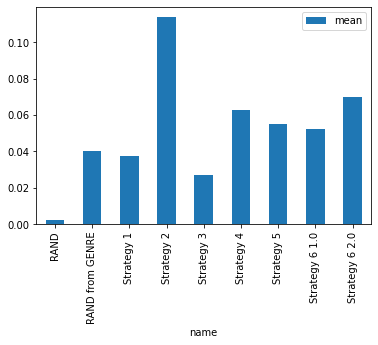

In [ ]:
_ = scores.plot.bar(x = "name", y = "mean")

In [ ]:
scores['mean_genre'] = scores[["jazz","pop", "raggae", "rock", "techno", "romance"]].mean(axis = 1)
scores['mean_mood'] = scores[["casual_run","roadtrip"]].mean(axis = 1)

scores

,name,jazz,pop,raggae,rock,romance,techno,roadtrip,casual_run,mean,mean_genre,mean_mood
0,RAND,0.00,0.000000,0.020,0.00000,0.000,0.000,0.000,0.000000,0.002500,0.003333,0.000000
1,RAND from GENRE,0.08,0.120000,0.000,0.03000,0.030,0.000,0.060,0.000000,0.040000,0.043333,0.030000
2,Strategy 1,0.30,0.000000,0.000,0.00000,0.000,0.000,0.000,0.000000,0.037500,0.050000,0.000000
3,Strategy 2,0.38,0.050000,0.020,0.00000,0.120,0.170,0.140,0.030000,0.113750,0.123333,0.085000
4,Strategy 3,0.06,0.044898,0.056,0.00625,0.012,0.012,0.022,0.004167,0.027164,0.031858,0.013083
5,Strategy 4,0.20,0.040000,0.120,0.00000,0.000,0.080,0.060,0.000000,0.062500,0.073333,0.030000
6,Strategy 5,0.10,0.060000,0.060,0.00000,0.050,0.090,0.060,0.020000,0.055000,0.060000,0.040000
7,Strategy 6 1.0,0.12,0.040000,0.020,0.02000,0.020,0.140,0.040,0.020000,0.052500,0.060000,0.030000
8,Strategy 6 2.0,0.10,0.080000,0.060,0.00000,0.060,0.140,0.120,0.000000,0.070000,0.073333,0.060000


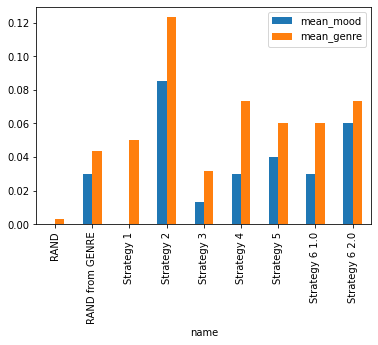

In [ ]:
_ = scores.plot.bar(x = "name", y = ["mean_mood", "mean_genre"])

## Conclusion

We've applied many strategies that were mostly based on artist similarity and their clustering, being deterministic by clustering them by genre or clustering similar artists together based on Spotify's definition of similarity (mostly being that the two artists share a large portition of their fanbase). 

### Baseline models
The first two strategies are baselines that we would compare our models to. They solely represent methods that would be applied to the dataset of connected data from Spotify and don't require graphs. The first baseline model consists of choosing an artist at random and, as expected, it behaves poorly, mostly due to the fact that our dataset contains at least 22,472 artists, we're picking 10 artists and checking if they are in a playlist that have a maximum of 100 songs. It is obvious to note that having a match is unlikely. 

The second model picks an artist at random from the playlist and then predicts 10 artists that share the same genre based on Spotify's dataset. This model however has better predictions. That could be mostly related to the fact that some playlist are playlists build around specific genres. However, playlist that revolve around mood are still poorly predicted.

### Graph Mining Algorithms
5 strategies and 2 additional hybrid ones were applied to leverage the graph's information and recommend songs to the playlist. All of these models outperform the first baseline models, however, 2 of them were challenged by the second baseline model. 

We've noticed that personnalized pagerank was the best strategy to follow for both genre and mood playlist. It made sense that recommending the most important artists doesn't outperform the personnalized version of pagerank and that is due to the fact that we're not recommending artists in viral or trendy playlist but in playlists that are focused on a topic being a genre or a mood. That being said, the most similar artists to ones that are already in the playlist would be the best way to go about solving this problem. 

Clustering the graph and using it to predict artists has been challenging and that might mostly be due to the fact that we weren't sure how many clusters to expect and that we poorly controlled the resolution of the model. Also, we didn't control the size of the clusters and they may have been very disproportionate, and that could also affect the quality of the prediction since we're randomly choosing artists from clusters. In order to solve some of these issues, another strategy consisted on building a hierarchical clustering of the graph and choose some artists from the same cluster and others from adjacent clusters (clusters that are in the same hierarchy). The hierarchical model was able to outperform our baselines for both genre and mood playlists.

Heat diffusion showed promising results but the challenge when using this method was to choose the nodes that would have an opposite temperature. We applied heat diffusion by choosing nodes who had opposite temperature on random and that model still outperformed both baseline models and the first clustering model. In an attempt to improve its results, we tried to choose these nodes more wisely by combining clustering and heat diffusion. First, we clustered the graph using the Louvain algorithm and then made sure to choose opposite temperature nodes from cluster who didn't contain the playlist's artists. Second, we used the artists' genres indicated by Spotify to choose artists that didn't share the same genre as the ones that were in the playlist. Since the second model is more factual, it outperformed the one in which we used Louvain.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f097cab7-1c10-4895-8bcd-a2dad10333ae' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>